
# Рубежный контроль №2

## Методы построения моделей машинного обучения.

### Вариант №2

##### Выполнил: Борисочкин М. И., РТ5-61Б

### Текстовое описание набора данных

В качестве набора данных в данном варианте используется игрушечный датасет "Ирисы Фишера"([load_iris](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris)) из библиотеки scikit-learn.

В данном датасете присутствуют следующие столбцы:

- sepal length — длина чашелистика в см;
- sepal width — ширина чашелистика в см;
- petal length — длина лепестка в см;
- petal width — ширина лепестка в см;
- target — целевой признак. Представляет собой виды ирисов: Iris setosa (0), Iris versicolor (1), Iris virginica (2).


### Импорт библиотек


In [1]:
from operator import itemgetter
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

%matplotlib inline
sns.set(style='ticks')


### Загрузка данных

In [2]:
# Загрузка датасета
iris = load_iris(as_frame=True)
data : pd.DataFrame = iris.frame


### Разведочный анализ данных

In [3]:
# Первые 5 строк датасета
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# Последние 5 строк датасета
data.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [5]:
# Размер датасета
data.shape

(150, 5)

In [6]:
# Типы данных в столбцах
data.dtypes

sepal length (cm)    float64
sepal width (cm)     float64
petal length (cm)    float64
petal width (cm)     float64
target                 int32
dtype: object

In [7]:
# Пустые значения
data.isnull().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [8]:
# Статистические характеристки датасета
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [9]:
# Датасет для визуализации
data_to_visualize = data.copy()
data_to_visualize['target'] = data_to_visualize['target'].\
    map({i : iris.target_names[i] for i in range(0, len(iris.target_names))})
data_to_visualize.sample(5, random_state=1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
14,5.8,4.0,1.2,0.2,setosa
98,5.1,2.5,3.0,1.1,versicolor
75,6.6,3.0,4.4,1.4,versicolor
16,5.4,3.9,1.3,0.4,setosa
131,7.9,3.8,6.4,2.0,virginica


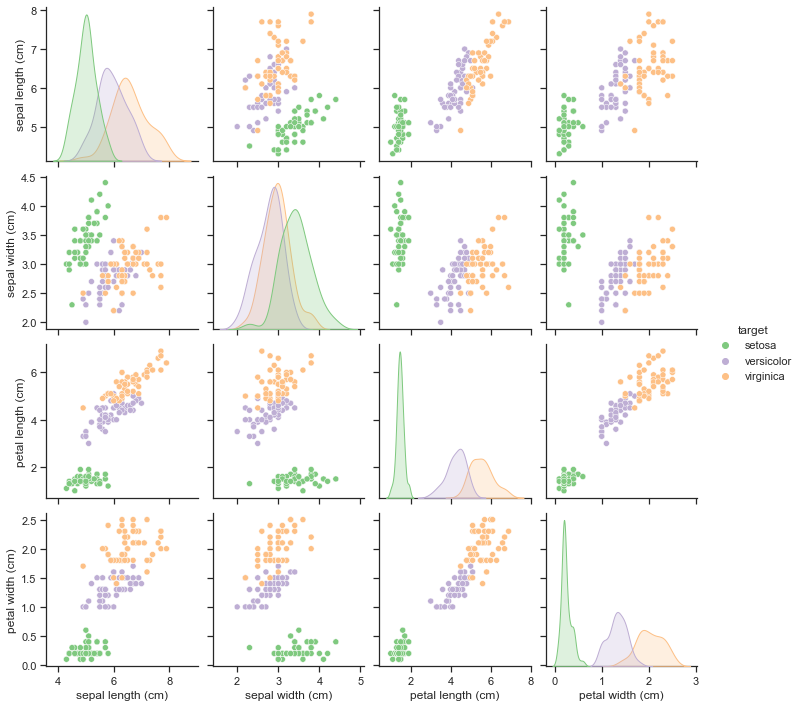

In [10]:
# Парные диаграммы
sns.pairplot(data=data_to_visualize, hue='target', palette='Accent')
plt.show()

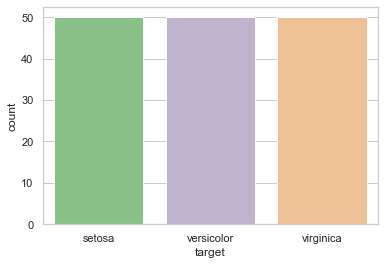

In [11]:
# График распределения классов
with sns.axes_style('whitegrid'):
    sns.countplot(x='target', data=data_to_visualize, palette='Accent')
    plt.show()

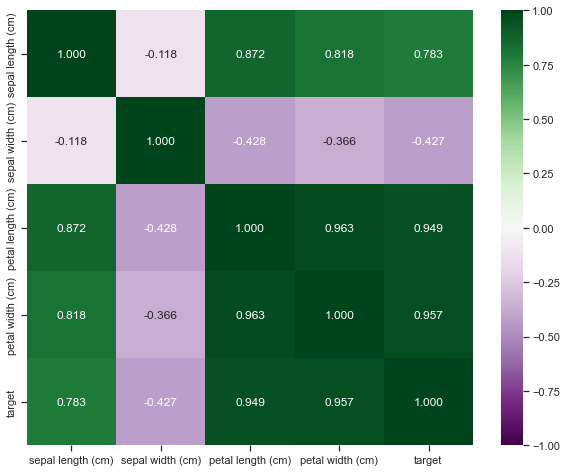

In [12]:
# Тепловая карта корреляционной матрицы
plt.figure(figsize=(10,8))
sns.heatmap(data=data.corr(), annot=True, vmin=-1, vmax=1,  fmt='.3f', cmap='PRGn')
plt.show()

*Примечание:* Корреляционная матрица построена для справки. Модели, которые мы будем использовать (дерево решений и градиентный бустинг) иммуны к мультиколлинеарности.


### Разбиение выборки


In [13]:
X = data.drop(columns=['target'])
y = data['target']
X_train : pd.DataFrame
X_test : pd.DataFrame
y_train : pd.Series
y_test : pd.Series

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)


### Дерево решений


In [14]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'max_depth' : np.arange(1, 6, 1), # 1-5
                      'min_samples_leaf' : np.linspace(0.02, 0.1, 5),
                      'max_features' : [0.2 , 0.4, 0.6, 0.8, 'auto', 'sqrt', 'log2']}

In [15]:
%%time
# Оптимизация гиперпараметров
dtc_gs = GridSearchCV(DecisionTreeClassifier(random_state=3),
                      parameters_to_tune, cv=5, scoring='accuracy')
dtc_gs.fit(X_train, y_train)

CPU times: total: 2.31 s
Wall time: 2.33 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=3),
             param_grid={'max_depth': array([1, 2, 3, 4, 5]),
                         'max_features': [0.2, 0.4, 0.6, 0.8, 'auto', 'sqrt',
                                          'log2'],
                         'min_samples_leaf': array([0.02, 0.04, 0.06, 0.08, 0.1 ])},
             scoring='accuracy')

In [16]:
# Лучшее значение параметров
dtc_gs.best_params_

{'max_depth': 2, 'max_features': 0.8, 'min_samples_leaf': 0.02}

In [17]:
# Лучшее значение метрики
dtc_gs.best_score_

0.9416666666666668

In [18]:
# Обучение модели
dt_classifier : DecisionTreeClassifier = dtc_gs.best_estimator_
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_features=0.8, min_samples_leaf=0.02,
                       random_state=3)

In [19]:
# Предсказания модели регрессора на основе дерева решений
dt_pred = dt_classifier.predict(X_test)

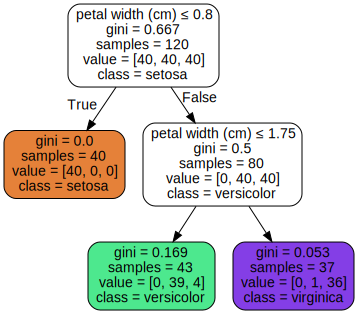

In [20]:
# Визуализация дерева с помощью графа
dot_data = export_graphviz(dt_classifier, feature_names=list(X_train.columns),
                           class_names=iris.target_names, filled=True,
                           rounded=True, special_characters=True)
graphviz.Source(dot_data)

In [21]:
def plot_feature_importances(feature_names, feature_importances):
    """
    Функция визуализации важности признаков

    :param feature_names: Названия признаков
    :param feature_importances: Важности признаков
    """
    feature_importance_list = list(zip(feature_names, feature_importances))
    sorted_list = sorted(feature_importance_list, key=itemgetter(1), reverse=True)
    feature_order = [x for x, _ in sorted_list]

    plt.figure(figsize=(9,6))
    bar_plot = sns.barplot(x=feature_names, y=feature_importances, order=feature_order)
    bar_plot.bar_label(bar_plot.containers[-1], fmt='%.3f')
    plt.show()

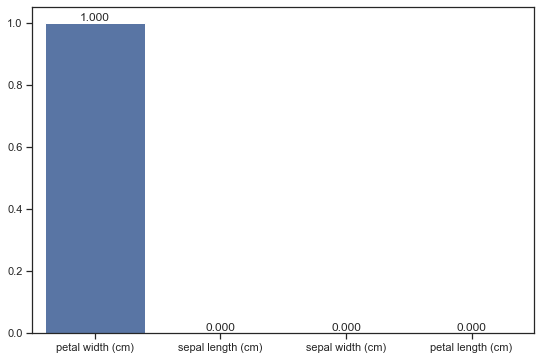

In [22]:
# Визуализация важности признаков
plot_feature_importances(X.columns.values, dt_classifier.feature_importances_)


### Градиентный бустинг


In [23]:
# Гиперпараметры для оптимизации
parameters_to_tune = {'n_estimators' : [2, 5, 10],
                      'learning_rate': np.linspace(0.1, 0.3, 3),
                      'min_samples_split': np.arange(2, 5, 1), # 2-4
                      'max_depth' : np.arange(1, 5, 1)} # 1-4

In [24]:
%%time
# Оптимизация гиперпараметров
gbc_gs = GridSearchCV(GradientBoostingClassifier(random_state=3),
                      parameters_to_tune, cv=5, scoring='accuracy')
gbc_gs.fit(X_train, y_train)

CPU times: total: 5.17 s
Wall time: 5.22 s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=3),
             param_grid={'learning_rate': array([0.1, 0.2, 0.3]),
                         'max_depth': array([1, 2, 3, 4]),
                         'min_samples_split': array([2, 3, 4]),
                         'n_estimators': [2, 5, 10]},
             scoring='accuracy')

In [25]:
# Лучшее значение параметров
gbc_gs.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_samples_split': 2,
 'n_estimators': 5}

In [26]:
# Лучшее значение метрики
gbc_gs.best_score_

0.95

In [27]:
# Обучение модели
gb_classifier : GradientBoostingClassifier = gbc_gs.best_estimator_
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=5, random_state=3)

In [28]:
# Предсказания модели регрессора на основе градиентного бустинга
gb_pred = gb_classifier.predict(X_test)

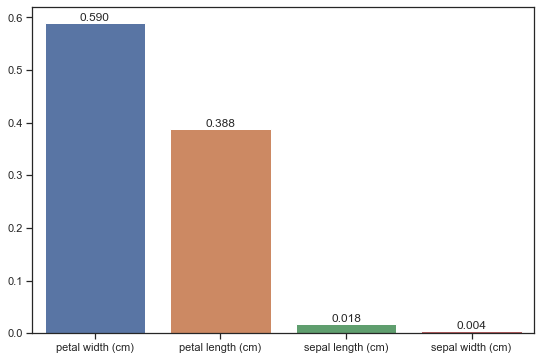

In [29]:
# Визуализация важности признаков
plot_feature_importances(X.columns.values, gb_classifier.feature_importances_)


### Оценка качества моделей

В качестве метрик будем использовать accuracy (проста для понимания), precision, recall и F1-меру (для более полной оценки моделей). Также, чтобы оценить каждый класс по отдельности воспользуемся матрицей ошибок.

In [30]:
def model_scoring(y_true, y_pred):
    """
    Функия для оценки качества модели

    :param y_true: Истинные значения целевого признака
    :param y_pred: Предсказанные значения целевого признака
    """

    print('Accuracy: {};'.format(accuracy_score(y_true, y_pred)))
    print('Precision: {};'.format(precision_score(y_true, y_pred, average='weighted')))
    print('Recall: {};'.format(recall_score(y_true, y_pred, average='weighted')))
    print('F1-score: {}.'.format(f1_score(y_true, y_pred, average='weighted')))

In [31]:
# Оценка качества дерева решений
print('Дерево решений')
model_scoring(y_test, dt_pred)

Дерево решений
Accuracy: 0.9666666666666667;
Precision: 0.9696969696969696;
Recall: 0.9666666666666667;
F1-score: 0.9665831244778613.


In [32]:
# Оценка качества градиентного бустинга
print('Градиентный бустинг')
model_scoring(y_test, gb_pred)

Градиентный бустинг
Accuracy: 1.0;
Precision: 1.0;
Recall: 1.0;
F1-score: 1.0.


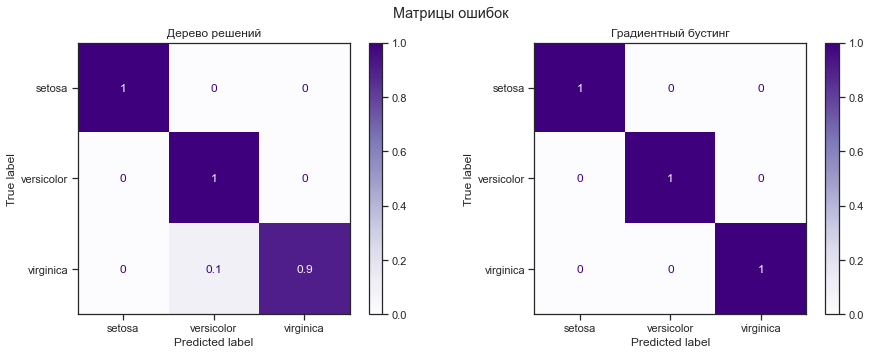

In [33]:
# Тепловые карты матриц ошибок
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, dt_pred,
                                        display_labels=iris.target_names,
                                        normalize='true', ax=ax[0], cmap='Purples')
ConfusionMatrixDisplay.from_predictions(y_test, gb_pred,
                                        display_labels=iris.target_names,
                                        normalize='true', ax=ax[1], cmap='Purples')
fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('Дерево решений')
ax[1].title.set_text('Градиентный бустинг')
plt.show()

Построенные модели с очень высокой точностью решают задачу классификации. Градиентный бустинг показал себя лучше дерева решений. Также плюсом градиентного бустинга является его невосприимчивость к переобучению.